<div style="background-image:url(images/meschede-seismic-waves.png); padding: 10px 30px 20px 30px; background-size:cover; background-opacity:50%; border-radius:5px; background-position: 0px -200px">
<p style="float:right; margin-top:20px; padding: 20px 60px 0px 10px; background:rgba(255,255,255,0.75); border-radius:10px;">
<img width="400px" src=images/obspy_logo_full_524x179px.png?raw=true>
</p>

<h1 style="color:#BBB; padding-bottom: 80px">MESS 2016 - Practicals</h1>

<h2 style="color:#FFF; padding-bottom: 30px">Similarity Analysis /<br/>Hierarchical Clustering</h2>

</div>

### Please execute first cell to have plots show up inline (and scrollable/zoomable)
### If you are unclear about how to use some ObsPy function: use search box at http://docs.obspy.org

In [1]:
import matplotlib.pyplot as plt
plt.switch_backend("nbagg")
plt.style.use("bmh")
import warnings
warnings.filterwarnings("ignore", message='The resource identifier.*')

 * read event data (file `clustering45_events.quakeml`)
 * read waveform data (file `clustering45_waveforms.mseed`)
 * print basic info of stream and catalog object

In [2]:
from obspy import read, read_events

# waveform data:
st = read("data/clustering45_waveforms.mseed")
# catalog data:
cat = read_events("data/clustering45_events.quakeml")

print(st)
print(cat)

912 Trace(s) in Stream:

BW.UH1..EHN | 2010-05-22T16:56:42.745000Z - 2010-05-22T16:57:22.745000Z | 200.0 Hz, 8001 samples
...
(910 other traces)
...
BW.UH4..EHN | 2012-05-13T03:08:27.845000Z - 2012-05-13T03:09:07.845000Z | 200.0 Hz, 8001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
45 Event(s) in Catalog:
2010-05-22T16:57:01.229287Z | +48.045,  +11.638 | 0.660187289567 Ml
2010-05-27T15:24:25.120781Z | +48.048,  +11.646 | 0.650501974417 Ml
...
2014-08-01T22:36:22.542204Z | +48.047,  +11.645 | 0.602489884872 Ml
2015-05-17T04:00:37.101399Z | +48.054,  +11.645 | 0.766291744254 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'


 * iterate over catalog and assemble a list of picks for station "UH1", phase "P" (event data is set up such that each event holds exactly one P pick with these criteria)
 * note: if your computer is slow you can shorten the list to only 20 or 10 picks later on..
 * (Gold card members: Make the assembling of the list failsafe, i.e. account for events missing a "P" pick or having multiple "P" picks for this station, etc...)

In [3]:
STATION = "UH1"
PHASE = "P"

picks = []
for event in cat:
    for pick in event.picks:
        if pick.waveform_id.station_code == STATION and pick.phase_hint == PHASE:
            picks.append(pick)
            break
    else:
        raise Exception("Missing pick for event {}!".format(str(event.resource_id)))

 * use function `get_matching_trace()` defined in the box below (execute box!) and fetch the corresponding traces for the first two picks in your list
 * use function `xcorr_pick_correction()` from `obspy.signal.cross_correlation` to calculate the correction time and maximum correlation coefficient for the second pick relative to the first pick (try with/without filtering options, use option `plot=True` to visualize the cross correlation) 

In [4]:
def get_matching_trace(stream, pick):
    """
    Extracts the appropriate Trace given a stream and a pick.
    
    stream: obspy Stream object
    pick: obspy Pick object
    """
    channel = pick.waveform_id.channel_code
    station = pick.waveform_id.station_code
    for tr in stream.select(station=station, channel=channel):
        if tr.stats.starttime < pick.time < tr.stats.endtime:
            return tr
    else:
        raise Exception("No matching trace found.")

# if you had problems getting the list of picks,
# use this function which returns the list of picks..
def get_pick_list():
    """
    Returns a list of picks used in exercises below.
    """
    from obspy import read_events
    return [pick for event in read_events("data/clustering45_events.quakeml")
            for pick in event.picks
            if pick.waveform_id.station_code == "UH1"
            and pick.phase_hint == "P"]

/home/megies/git/obspy/obspy/signal/cross_correlation.py:344: UserWarning: Maximum of cross correlation lower than 0.8: 0.709898403761
  warnings.warn(msg)


<IPython.core.display.Javascript object>


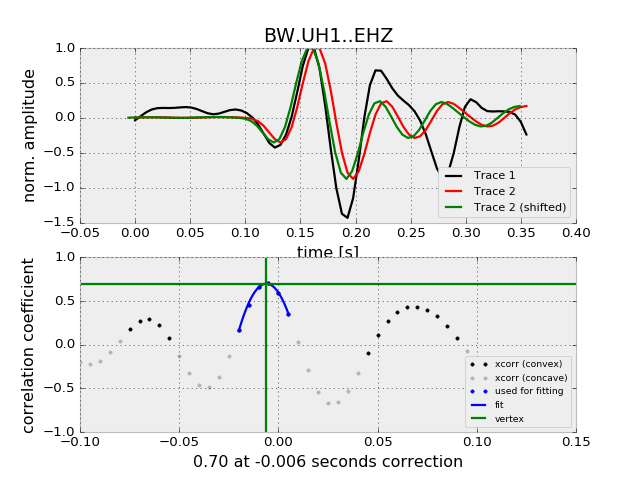

(0.0060621237444837134, 0.69993618008617331)

In [5]:
from obspy.signal.cross_correlation import xcorr_pick_correction

pick1 = picks[0]
pick2 = picks[5]

tr1 = get_matching_trace(stream=st, pick=pick1)
tr2 = get_matching_trace(stream=st, pick=pick2)

xcorr_pick_correction(
    pick1.time, tr1, pick2.time, tr2,
    t_before=0.05, t_after=0.2, cc_maxlag=0.10,
    filter="bandpass", filter_options={'freqmin': 1, 'freqmax': 20},
    plot=True)

 * in the box below, we do the cross-correlation pick alignment for each pair of events and save the maximum correlation coefficient of the "P" pick on station "UH1" as the similarity
 * we plot a histogram of all correlation coefficients and the similarity matrix
 * (Gold card members: Do similarity analysis using multiple stations, use average of stations as similarity; optionally include alos "S" picks in calculation (beware: picks might be set on different horizontal components!))

In [6]:
import warnings
import numpy as np
from obspy.signal.cross_correlation import xcorr_pick_correction

# if calculation takes too long on slow computers:
# restrict length of pick list or use lower `cc_maxlag`
similarity = np.eye(len(picks))
for i, pick1 in enumerate(picks):
    # here we select the correct trace for pick1
    tr1 = get_matching_trace(st, pick1)
    for j, pick2 in enumerate(picks):
        if j <= i:
            continue
        tr2 = get_matching_trace(st, pick2)
        # we ignore warnings in the pick alignment for now.. too much output ;-)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            _, coeff = xcorr_pick_correction(
                pick1.time, tr1, pick2.time, tr2,
                t_before=0.05, t_after=0.2, cc_maxlag=0.10,
                filter="bandpass", filter_options={'freqmin': 1, 'freqmax': 20},
                plot=False)
        similarity[i, j] = coeff
        similarity[j, i] = coeff

<IPython.core.display.Javascript object>


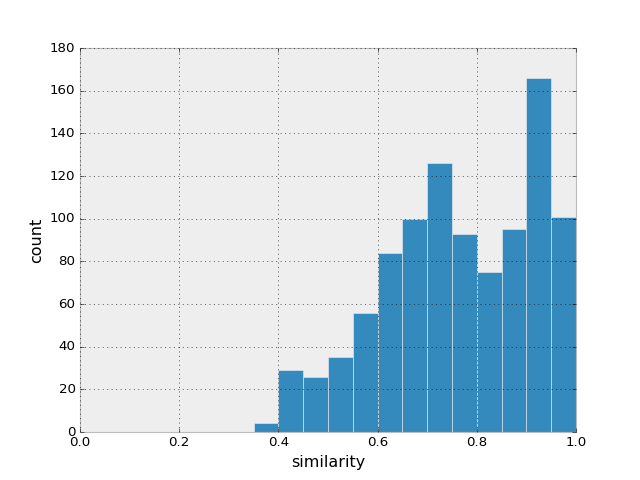

In [7]:
# plot histogram
def plot_histogram(similarity):
    plt.figure()
    upper_triangle = similarity[np.triu_indices(similarity.shape[0], k=1)]
    plt.hist(upper_triangle.flatten(), bins=np.linspace(0, 1, 21))
    plt.ylabel("count")
    plt.xlabel("similarity")
    plt.show()

plot_histogram(similarity)

 * visualize similarity matrix using `matplotlib`'s `imshow()` function (avoid interpolation by setting `interpolation="nearest"`)
 * (Gold card members: use a custom colormap, e.g. "viridis" from `obspy.imaging.cm`)
 * (Gold card members: plot the picks over time, to get an idea of the relative timing within groups of similar events)
 * optionally, save the similarity matrix to a numpy binary file using numpy's `save()` function
 * can you make out event clusters already in the matrix plot?

<IPython.core.display.Javascript object>


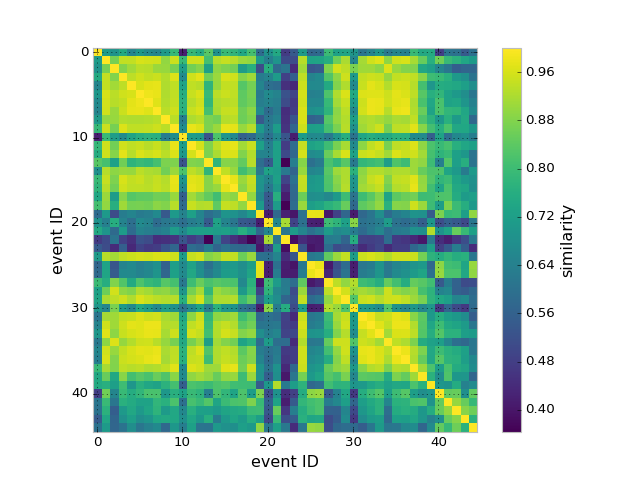

In [8]:
from obspy.imaging.cm import viridis
import matplotlib.pyplot as plt

plt.imshow(similarity, interpolation="nearest", cmap=viridis)
plt.xlabel("event ID")
plt.ylabel("event ID")
cb = plt.colorbar()
cb.ax.set_ylabel("similarity")
plt.show()

np.save("data/clustering_similarity.npy", similarity)

 * Here we calculate the linkage of the similarity matrix (i.e. we do the agglomerative clustering) and plot the dendrogram of the resulting clusters (given a certain cut-off criterion in the clustering)
 * try different linkage methods (one of "single", "complete", "average", "weighted"; check documentation of `linkage` function to see what they do) and cut-off threshold values and see how it affects the clustering results
 * (Gold card members: plot corresponding seismograms in a subplot to the right, in line with dendrogram)

<IPython.core.display.Javascript object>


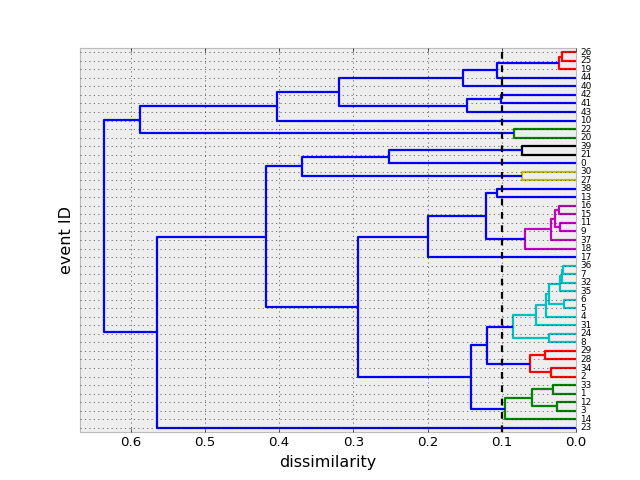

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

linkage_method = "complete"
dissimilarity_threshold = 0.1


distance = squareform(1 - similarity)
linkage_matrix= linkage(distance, method=linkage_method)

dendrogram(linkage_matrix, color_threshold=dissimilarity_threshold, orientation="right")

import matplotlib.pyplot as plt
plt.axvline(dissimilarity_threshold, color="k", ls="--")
plt.xlabel("dissimilarity")
plt.ylabel("event ID")
plt.show()